# **Test rag implementation with langchain**

## Document preprocessing with langchain to load, split and embed and vectorize

In [1]:
from dotenv import load_dotenv

env = load_dotenv()
print(env)

True


Load document from file


In [29]:
from langchain_community.document_loaders import PyPDFLoader

# file_path = "/Users/mathieumuty/Repository/test/ai-test/dev/datasets/docker_cheatsheet_cli.pdf"
file_path = "/Users/mathieumuty/Repository/test/ai-test/dev/datasets/rfc6750.pdf"
loader = PyPDFLoader(file_path)

docs = loader.load()

print(len(docs))

18


Print head of the docs to see the content

In [30]:
print(f"{docs[0].page_content[:200]}\n")
print(docs[0].metadata)

Internet Engineering Task Force (IETF)                          M. Jones
Request for Comments: 6750                                     Microsoft
Category: Standards Track                             

{'producer': 'GPL Ghostscript 8.62', 'creator': 'GNU enscript 1.6.4', 'creationdate': '2012-10-12T15:41:32-07:00', 'moddate': '2012-10-12T15:41:32-07:00', 'title': 'Enscript Output', 'author': 'RFC Editor', 'source': '/Users/mathieumuty/Repository/test/ai-test/dev/datasets/rfc6750.pdf', 'total_pages': 18, 'page': 0, 'page_label': '1'}


Split the document into chunks

In [31]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000, chunk_overlap=200, add_start_index=True
)
all_splits = text_splitter.split_documents(docs)

len(all_splits)

53

Embed the chunks

In [32]:
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model="text-embedding-3-large")
vector_1 = embeddings.embed_query(all_splits[0].page_content)
vector_2 = embeddings.embed_query(all_splits[1].page_content)

assert len(vector_1) == len(vector_2)
print(f"Generated vectors of length {len(vector_1)}\n")
print(vector_1[:10])

Generated vectors of length 3072

[0.0001845460938056931, -0.05336429551243782, -0.005305427126586437, 0.009870794601738453, 0.0015176221495494246, 0.004175336100161076, -0.008800707757472992, 0.041963376104831696, -0.03458278253674507, -0.012240985408425331]


Store vector in in Memory langchain vector store

In [33]:
from langchain_core.vectorstores import InMemoryVectorStore

vector_store = InMemoryVectorStore(embeddings)
ids = vector_store.add_documents(documents=all_splits)

Test retrieval

In [34]:
results = vector_store.similarity_search(
    "What is an access token ?"
)

print(results[0])

page_content='RFC 6750              OAuth 2.0 Bearer Token Usage          October 2012
   The access token provides an abstraction, replacing different
   authorization constructs (e.g., username and password, assertion) for
   a single token understood by the resource server.  This abstraction
   enables issuing access tokens valid for a short time period, as well
   as removing the resource server’s need to understand a wide range of
   authentication schemes.
     +--------+                               +---------------+
     |        |--(A)- Authorization Request ->|   Resource    |
     |        |                               |     Owner     |
     |        |<-(B)-- Authorization Grant ---|               |
     |        |                               +---------------+
     |        |
     |        |                               +---------------+
     |        |--(C)-- Authorization Grant -->| Authorization |
     | Client |                               |     Server    |' meta

Test async retrieval

In [35]:
results = await vector_store.asimilarity_search("How to delete a volume?")

print(results[0])

page_content='protected from disclosure in storage and in transport.
Status of This Memo
   This is an Internet Standards Track document.
   This document is a product of the Internet Engineering Task Force
   (IETF).  It represents the consensus of the IETF community.  It has
   received public review and has been approved for publication by the
   Internet Engineering Steering Group (IESG).  Further information on
   Internet Standards is available in Section 2 of RFC 5741.
   Information about the current status of this document, any errata,
   and how to provide feedback on it may be obtained at
   http://www.rfc-editor.org/info/rfc6750.
Copyright Notice
   Copyright (c) 2012 IETF Trust and the persons identified as the
   document authors.  All rights reserved.
   This document is subject to BCP 78 and the IETF Trust’s Legal
   Provisions Relating to IETF Documents
   (http://trustee.ietf.org/license-info) in effect on the date of' metadata={'producer': 'GPL Ghostscript 8.62', 'cr

Return chunk of doc associated with the vector

In [36]:
embedding = embeddings.embed_query("What are the security threat ?")

results = vector_store.similarity_search_by_vector(embedding)
print(results[0])

page_content='utilizing some form of tokens.  This list of threats is based on NIST
   Special Publication 800-63 [NIST800-63].  Since this document builds
   on the OAuth 2.0 Authorization specification [RFC6749], we exclude a
   discussion of threats that are described there or in related
   documents.
   Token manufacture/modification:  An attacker may generate a bogus
      token or modify the token contents (such as the authentication or
      attribute statements) of an existing token, causing the resource
      server to grant inappropriate access to the client.  For example,
      an attacker may modify the token to extend the validity period; a
      malicious client may modify the assertion to gain access to
      information that they should not be able to view.
   Token disclosure:  Tokens may contain authentication and attribute
      statements that include sensitive information.
Jones & Hardt                Standards Track                   [Page 10]' metadata={'producer

## Rag implementation


Load chatgpt client

In [28]:
from langchain_openai import ChatOpenAI


llm = ChatOpenAI()

In [ ]:
from langchain import hub

prompt = hub.pull("rlm/rag-prompt")

example_messages = prompt.invoke(
    {"context": "(i build an app and i implement my own version of 0Auth)", "question": "(what is a bearer token?)"}
).to_messages()

assert len(example_messages) == 1
print(example_messages[0].content)

You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: (what is a bearer token?) 
Context: (i build an app and i implement my own version of 0Auth) 
Answer:


In [45]:
from langchain_core.documents import Document
from typing_extensions import List, TypedDict
from typing import Literal
from typing_extensions import Annotated


class Search(TypedDict):
    """Search query."""
    query: Annotated[str, ..., "Search query to run."]
    section: Annotated[
        Literal["beginning", "middle", "end"],
        ...,
        "Section to query.",
    ]

class State(TypedDict):
    question: str
    query: Search
    context: List[Document]
    answer: str

def analyze_query(state: State):
    structured_llm = llm.with_structured_output(Search)
    query = structured_llm.invoke(state["question"])
    return {"query": query}


def retrieve(state: State):
    query = state["query"]
    retrieved_docs = vector_store.similarity_search(
        query["query"],
        filter=lambda doc: doc.metadata.get("section") == query["section"],
    )
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}

In [46]:
from langgraph.graph import START, StateGraph

graph_builder = StateGraph(State).add_sequence([analyze_query, retrieve, generate])
graph_builder.add_edge(START, "analyze_query")
graph = graph_builder.compile()

In [47]:
total_documents = len(all_splits)
third = total_documents // 3

for i, document in enumerate(all_splits):
    if i < third:
        document.metadata["section"] = "beginning"
    elif i < 2 * third:
        document.metadata["section"] = "middle"
    else:
        document.metadata["section"] = "end"


all_splits[0].metadata

{'producer': 'GPL Ghostscript 8.62',
 'creator': 'GNU enscript 1.6.4',
 'creationdate': '2012-10-12T15:41:32-07:00',
 'moddate': '2012-10-12T15:41:32-07:00',
 'title': 'Enscript Output',
 'author': 'RFC Editor',
 'source': '/Users/mathieumuty/Repository/test/ai-test/dev/datasets/rfc6750.pdf',
 'total_pages': 18,
 'page': 0,
 'page_label': '1',
 'start_index': 0,
 'section': 'beginning'}

In [48]:
from langchain_core.vectorstores import InMemoryVectorStore

vector_store = InMemoryVectorStore(embeddings)
_ = vector_store.add_documents(all_splits)

Get the result

In [49]:
result = graph.invoke({"question": "what is a bearer token?"})

print(f'Context: {result["context"]}\n\n')
print(f'Answer: {result["answer"]}')

/Users/mathieumuty/Repository/test/ai-test/dev/.venv/lib/python3.11/site-packages/langchain_openai/chat_models/base.py:1673: UserWarning: Cannot use method='json_schema' with model gpt-3.5-turbo since it doesn't support OpenAI's Structured Output API. You can see supported models here: https://platform.openai.com/docs/guides/structured-outputs#supported-models. To fix this warning, set `method='function_calling'. Overriding to method='function_calling'.
  warnings.warn(


Context: [Document(id='c0b730be-8d9d-4532-885e-2d5a59d96d13', metadata={'producer': 'GPL Ghostscript 8.62', 'creator': 'GNU enscript 1.6.4', 'creationdate': '2012-10-12T15:41:32-07:00', 'moddate': '2012-10-12T15:41:32-07:00', 'title': 'Enscript Output', 'author': 'RFC Editor', 'source': '/Users/mathieumuty/Repository/test/ai-test/dev/datasets/rfc6750.pdf', 'total_pages': 18, 'page': 4, 'page_label': '5', 'start_index': 832, 'section': 'beginning'}, page_content='practice outlined therein in order to reflect existing deployments.\n   The syntax for Bearer credentials is as follows:\n     b64token    = 1*( ALPHA / DIGIT /\n                       "-" / "." / "_" / "˜" / "+" / "/" ) *"="\n     credentials = "Bearer" 1*SP b64token\n   Clients SHOULD make authenticated requests with a bearer token using\n   the "Authorization" request header field with the "Bearer" HTTP\n   authorization scheme.  Resource servers MUST support this method.\n2.2.  Form-Encoded Body Parameter\n   When sending t

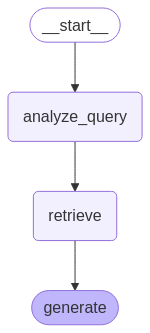

In [52]:
from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))